<h1>Lab 9 - Neural network-based committor solvers</h1>
<p>First, we'll generate uniformly sampled datapoints from a region around the wells in Meuller's potential using metadynamics and the delta-net algorithm (algorithm 3 from the Li Lin and Ren paper)</p>

In [2]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import torch
import torch as tc
import pandas as pd



In [3]:
 def mueller(x, y):
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])

    fx1 = D[0]*np.exp(a[0]*((x-X[0])**(2)) + b[0]*(x-X[0])*(y-Y[0]) + c[0]*((y-Y[0])**(2)))
    fx2 = D[1]*np.exp(a[1]*((x-X[1])**(2)) + b[1]*(x-X[1])*(y-Y[1]) + c[1]*((y-Y[1])**(2)))
    fx3 = D[2]*np.exp(a[2]*((x-X[2])**(2)) + b[2]*(x-X[2])*(y-Y[2]) + c[2]*((y-Y[2])**(2)))
    fx4 = D[3]*np.exp(a[3]*((x-X[3])**(2)) + b[3]*(x-X[3])*(y-Y[3]) + c[3]*((y-Y[3])**(2)))

    U = fx1+fx2+fx3+fx4
    return U

In [4]:
def grad_mueller(x, y):
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])    
    
    dVdx1, dVdx2 = 0, 0
    
    
    for i in np.arange(4):
        exp_comp = D[i]*np.exp(a[i]*((x-X[i])**(2))+ b[i]*(x-X[i])*(y-Y[i]) + c[i]*((y-Y[i])**(2)))
        dVdx1 += ( exp_comp * (2*a[i]*(x-X[i]) + b[i]*(y-Y[i])) )
        dVdx2 += ( exp_comp * (b[i]*(x-X[i]) + 2*c[i]*(y-Y[i])) )
        
    grad = np.array([dVdx1, dVdx2])

    return grad.reshape(1, -1)

<p>We will do metadynamics to run some trajectories on the Mueller potential. 
<p>Here we will initialize constants and allocate space. 

In [10]:
# Generate a dataset using metadynamics
# Parameters for metadynamics
Ndeposit = 500
Nbumps = 1000
height = 3
sig = 0.15
sig2 = sig**2
beta = 3.0;
h=1e-5 # time step
sqh = math.sqrt(h*2/beta)
traj = np.zeros((Ndeposit,2))
coef = np.zeros((Nbumps,1))
xbump = np.zeros((Nbumps,2))
# initial point
xa = 0
ya = 0
x0 = np.array([xa,ya])

<p>Here we will plot the Mueller's potential contours and perform the metadynamics. 

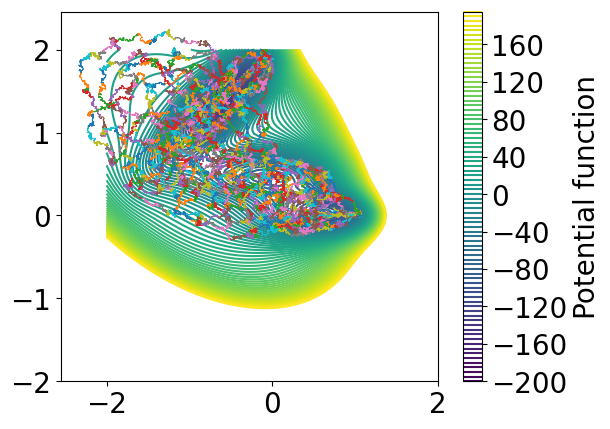

In [11]:
#plot the contours
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
gridpoints = np.c_[x_grid.ravel(), y_grid.ravel()]
v_grid = mueller(gridpoints[:,0], gridpoints[:,1])
v_grid = np.reshape(v_grid, x_grid.shape)
ls = plt.contour(x_grid,y_grid,v_grid,range(-200, 200, 5))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})


if metadynamics_flag:
    #perform and plot the metadynamics
    net_traj = np.zeros((Ndeposit*Nbumps, 2))
    for k in range(Nbumps):
        print(f'On bump #{k}/{Nbumps}', end='\r')
        traj[0,:] = x0
        w = sqh*np.random.normal(0,1,(Ndeposit-1,2))
        for j in range(Ndeposit-1):
            dVface = np.array(grad_mueller(traj[j][0],traj[j][1]));
            aux1 = np.reshape(traj[j][0]-xbump[:,0],(Nbumps,1))
            aux2 = np.reshape(traj[j][1]-xbump[:,1],(Nbumps,1))
            c1 = np.outer(coef,np.array([1,1]))
            c1aux = np.multiply(c1,np.hstack((aux1,aux2)))
            c1auxexp = np.multiply(c1aux,np.outer(np.exp(-(0.5/sig2)*np.array(aux1**2+aux2**2)),np.array([1,1])))
            dVbump = np.sum(c1auxexp,axis=0)/sig2;
            traj[j+1,:] = traj[j,:] - h*(dVface-dVbump) + w[j,:];
        plt.plot(traj[:,0],traj[:,1], linewidth=.5)
        net_traj[Ndeposit*k:Ndeposit*(k+1)]=traj
        # deposit bump
        x0 = traj[j+1,:]
        xbump[k,:] = x0
        coef[k] = height;
else:
    traj = 
plt.show()

In [12]:
all_datapoints = pd.DataFrame(net_traj)
#all_datapoints.to_csv('./generated_data/All Mueller Metadynamics Points.csv')

<p>Now we'll impliment the delta-net algorithm on these data points to get points that are uniformly distributed on the region. 

In [14]:
def delta_net(traj, delta, pflag=False):
    #main algorithm
    Z = traj
    Zboolindex = np.zeros(shape=Z.shape[0], dtype='bool')
    Zboolindex[0] = True
    
    
    for i in range(1, len(Z)):
        point = Z[i]
        dists = np.sqrt(np.sum((Z[Zboolindex]-np.reshape(point, (1, -1)))**2, axis=1))
        if dists.min() > delta:
            Zboolindex[i] = True
        print(f'Checked {i}/{len(Z)} points'+' '*20,end = '\r')
            
    
    Z = Z[Zboolindex]
    Zboolindex = np.full(len(Z), 1, dtype='bool')
    print('Delta-Net complete, removing extraneous points')
    
    for i in range(0, len(Z)):
        Zboolindex[i] = False
        point = Z[i]
        
        dists = np.sqrt(np.sum((Z[Zboolindex]-np.reshape(point, (1, -1)))**2, axis=1))
        Zboolindex[i] = True
        if dists.min() > 2*delta:
            Zboolindex[i] = False
        print(f'Checked {i}/{len(Z)} points'+' '*20,end = '\r')
    
    Z = Z[Zboolindex]
    print('Done!')
    return Z

<p>Below the delta net points are displayed. 

In [15]:
mynet = delta_net(net_traj, .01, pflag=True)

KeyboardInterrupt: 

[[ 0.          0.        ]
 [ 0.10634481  0.04647435]
 [ 0.14835525  0.11600162]
 ...
 [-1.40517489  1.97885868]
 [-1.43659729  1.96554283]
 [-1.30352265  1.98807852]]


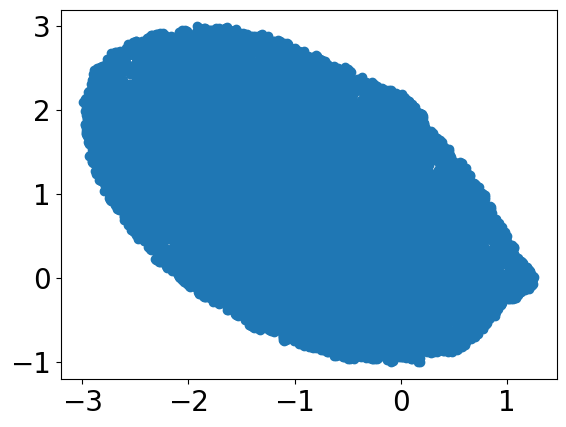

In [23]:
mynet = np.genfromtxt('./generated_data/Deltanet Points of Mueller Potential.csv', delimiter=',')[1:,1:]
plt.scatter(mynet[:,0], mynet[:,1])
print(mynet)

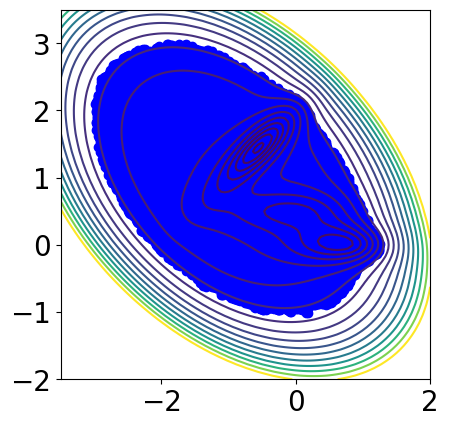

In [25]:
x_grid = np.linspace(-3.5, 2, 100)
y_grid = np.linspace(-2, 3.5, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
gridpoints = np.c_[x_grid.ravel(), y_grid.ravel()]
v_grid = mueller(gridpoints[:,0], gridpoints[:,1])
v_grid = np.reshape(v_grid, x_grid.shape)
ls = plt.contour(x_grid,y_grid,v_grid, np.exp(np.linspace(-5, 8, 60))-200)
#plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.scatter(mynet[:,0], mynet[:,1], c='b')
plt.show()

In [26]:
print(mynet.shape)

(25987, 2)


In [ ]:
#deltanet_points = pd.DataFrame(mynet)
#deltanet_points.to_csv('./generated_data/Deltanet Points of Mueller Potential.csv')

<h1>Neural Network</h1>
<p>Below, we will implement a neural network on our datapoints in order to approximate the committor function. <p>

<p>We will write the function for the Meuller potential in a way compatible with PyTorch so it works with the autodifferentiation library. 

In [29]:
def mueller_t(x, y):
    a = tc.tensor([-1,-1,-6.5,0.7])
    b = tc.tensor([0,0,11,0.6])
    c = tc.tensor([-10,-10,-6.5,0.7])
    D = tc.tensor([-200,-100,-170,15])
    X = tc.tensor([1,0,-0.5,-1])
    Y = tc.tensor([0,0.5,1.5,1])
    
    try:
        fx1 = D[0]*torch.exp(a[0]*((x-X[0]).pow(2)) + b[0]*(x-X[0])*(y-Y[0]) + c[0]*((y-Y[0]).pow(2)))
        fx2 = D[1]*torch.exp(a[1]*((x-X[1]).pow(2)) + b[1]*(x-X[1])*(y-Y[1]) + c[1]*((y-Y[1]).pow(2)))
        fx3 = D[2]*torch.exp(a[2]*((x-X[2]).pow(2)) + b[2]*(x-X[2])*(y-Y[2]) + c[2]*((y-Y[2]).pow(2)))
        fx4 = D[3]*torch.exp(a[3]*((x-X[3]).pow(2)) + b[3]*(x-X[3])*(y-Y[3]) + c[3]*((y-Y[3]).pow(2)))

        U = fx1+fx2+fx3+fx4
        return U
    except:
        return mueller_t(torch.from_numpy(x), torch.from_numpy(y))

<p>Here, we will plot some contours of the Mueller potential in order to see the potential wells.

In [30]:
xytrain = pd.read_csv(r'./generated_data/Deltanet Points of Mueller Potential.csv')
xytrain = xytrain.to_numpy()[:,1:]
print(xytrain[0:10,:])

train_data = torch.from_numpy(xytrain).float()
train_data.requires_grad_(True)
print(train_data[0:10,:])

size1, size2 = train_data.shape
print(size1, size2)

[[0.         0.        ]
 [0.10634481 0.04647435]
 [0.14835525 0.11600162]
 [0.22876928 0.1035085 ]
 [0.32285327 0.09883963]
 [0.39205721 0.03327946]
 [0.45647002 0.02913519]
 [0.50470586 0.0240166 ]
 [0.59169069 0.03085389]
 [0.56468951 0.03910782]]
tensor([[0.0000, 0.0000],
        [0.1063, 0.0465],
        [0.1484, 0.1160],
        [0.2288, 0.1035],
        [0.3229, 0.0988],
        [0.3921, 0.0333],
        [0.4565, 0.0291],
        [0.5047, 0.0240],
        [0.5917, 0.0309],
        [0.5647, 0.0391]], grad_fn=<SliceBackward0>)
25987 2


<p>Here we will define the committor neural network. We use $\tanh$ as the activation function because it is continuous, which is a necessary condition for a theorem that says the function can be arbitrarily well-approximated by a neural network. 

In [31]:
class CommittorModelNN(torch.nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(CommittorModelNN, self).__init__()
        
        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_size, out_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x, a, b, ra, rb):
        q = self.linear0(x)
        q = self.activation0(q)
        q = self.linear1(q)
        q = self.activation1(q)
        q = self.linear2(q)
        q = self.sigmoid(q)
        sizex, _ = x.shape
        
        #here, we continuously approximate the indicator functions
        #with a smooth function
        aux0 = ( ((x-a).pow(2)).sum(dim=1) ).reshape(sizex, 1) - (ra + torch.tensor(0.02)).pow(2)
        aux1 = ( ((x-b).pow(2)).sum(dim=1) ).reshape(sizex, 1) - (rb + torch.tensor(0.02)).pow(2)
        
        chia = 0.5-0.5*torch.tanh(100 * aux0)
        chib = 0.5-0.5*torch.tanh(100 * aux1)
        
        q = (1-chia)*((1-chib)+q*chib)
        
        return q

<p>Here we will set the parameters for $\beta$ (the inverse temperature, just a parameter) and the sets around the attractors. 

In [32]:
beta = torch.tensor(0.1)

a = torch.tensor([.5, 0])
b = torch.tensor([-.5, 1.5])
ra = .25
rb = .25

in_size = 2
hidden_size = 40
out_size = 1

<p>Code to test the neural network:

In [ ]:
qmodel = CommittorModelNN(in_size, hidden_size, out_size)
print(qmodel)
xy = train_data[0:2, :]
print(xy)
print("net = ",qmodel(xy, a, b, ra, rb))

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

rhs = torch.zeros(size1,)

train_dataset = TensorDataset(train_data, rhs)

batch_size = 256 # the batch size is the size of the training data/125

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

loss_fn = torch.nn.L1Loss()

optimizer1 = optim.Adam(qmodel.parameters(), lr = 1e-3)

#reduce the learning rate at the listed epochs by the factor of gamma
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[1000,2000,3000], gamma=0.1)


In [ ]:
loss = 1
for epoch in range(100):
    for X, y in train_dataloader:
        optimizer1.zero_grad()
        
        q = qmodel(X, a, b, ra, rb)
        
        V = mueller_t(X[:,0], X[:,1])
        
        #here, autograd is used to calculate the derivative of the function with respect to the input X
        
        derivQ = torch.autograd.grad(q, X, grad_outputs = torch.ones_like(q),
                                    allow_unused = True, retain_graph = True, create_graph = True)
        dq = derivQ[0]
        
        integrand = (torch.norm(derivQ[0],dim=1)**2)*torch.exp(-beta*V)
        
        loss = torch.sum(integrand)
        
        loss.backward()
        optimizer1.step()
    
    scheduler1.step()
    if epoch%10 == 0:
        print('epoch = ', epoch, 'loss: ', loss)

In [ ]:
# visualize the computed committor

q_train_data = qmodel(train_data,a,b,ra,rb)

t=np.linspace(0,2*np.pi,100)
Abdry_x = a[0] + ra*np.cos(t)
Abdry_y = a[1] + ra*np.sin(t)
Bbdry_x = b[0] + rb*np.cos(t)
Bbdry_y = b[1] + rb*np.sin(t)

plt.figure(figsize=(8, 8))
ls = plt.contour(x_grid,y_grid,v_grid,np.exp(np.linspace(-5, 8, 60))-200, colors='black')
plt.scatter(xytrain[:,0],xytrain[:,1],s = 6, c = q_train_data.detach(),cmap = "viridis")
#plt.plot(Abdry_x,Abdry_y,linewidth=3,color='white')
#plt.plot(Bbdry_x,Bbdry_y,linewidth=3,color='black')
plt.colorbar(label="Committor function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.plot()
#plt.savefig("FaceCommittorBeta1.pdf")

